In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

#### Dataset Source: https://community.qlik.com/t5/Qlik-Sense-Documents/AirPassengers-csv/ta-p/1476807

In [2]:
df = pd.read_csv('./AirPassengers.csv', parse_dates=['Month'], index_col=['Month'])

#### Plot Data

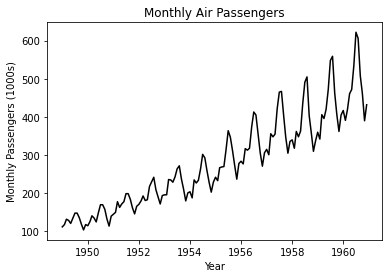

In [3]:
fig, ax = plt.subplots()
plt.xlabel('Year')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Air Passengers')
plt.plot(df, color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

#### Reshape Data

- Reshape the data into an n x (k + 1) matrix
- n = number of samples
- k = number of features, i.e., last 12 lags of the time series as features to capture a full seasonal cycle.

In [4]:
k = 12
Z = []

for i in range(k + 1, df.shape[0] + 1):
    Z.append(df.iloc[(i - k - 1): i, 0])

Z = np.array(Z)
Z.shape

(132, 13)

#### Split Data

- Use the first 80% of the data for training and the remaining 20% of the data for testing.

In [5]:
split = np.int(0.8 * Z.shape[0])
Z_train, Z_test = Z[:split, :], Z[split:, :]

#### Rescale Data

In [6]:
scaler = StandardScaler().fit(Z_train)
Z_train = scaler.transform(Z_train)
Z_test = scaler.transform(Z_test)

#### Extract the features (first 12 columns) and the target (last column).

In [7]:
X_train, y_train = Z_train[:, :-1], Z_train[:, -1]
X_test, y_test = Z_test[:, :-1], Z_test[:, -1]

#### Plot the normalized training data.

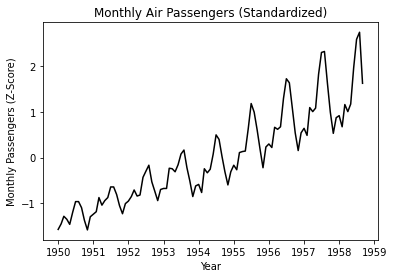

In [8]:
fig, ax = plt.subplots()
plt.xlabel('Year')
plt.ylabel('Monthly Passengers (Z-Score)')
plt.title('Monthly Air Passengers (Standardized)')
plt.plot(pd.Series(y_train, index=df.index[k: (k + len(y_train))]), color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

#### Plot the normalized testing data.

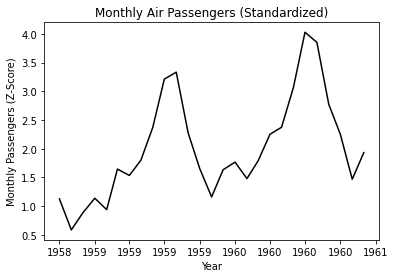

In [9]:
fig, ax = plt.subplots()
plt.xlabel('Year')
plt.ylabel('Monthly Passengers (Z-Score)')
plt.title('Monthly Air Passengers (Standardized)')
plt.plot(pd.Series(y_test, index=df.index[-len(y_test):]), color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

#### Fit an MLP Using 20% validation set

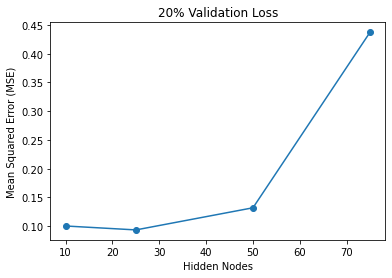

In [10]:
split_ = np.int(0.8 * X_train.shape[0])
X_train_, y_train_ = X_train[:split_, :], y_train[:split_]
X_valid_, y_valid_ =  X_train[split_:, :], y_train[split_:]

#Use the mean squared error (MSE) as validation loss.
def validation_loss(hidden_neurons):
    mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=500, random_state=1, shuffle=False)    
    mlp.fit(X_train_, y_train_)
    return mean_squared_error(y_valid_, mlp.predict(X_valid_))

params = [10, 25, 50, 75] # Calculate the validation loss corresponding to different numbers of hidden nodes.
mse = [validation_loss(p) for p in params]


fig, ax = plt.subplots()
plt.xlabel('Hidden Nodes')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('20% Validation Loss')
plt.plot(params, mse, '-o')

#### Use hidden nodes that gives smallest validation loss.

In [11]:
mlp = MLPRegressor(hidden_layer_sizes=(params[np.argmin(mse)],), max_iter=500, random_state=1, shuffle=False)
mlp.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(25,), max_iter=500, random_state=1,
             shuffle=False)

#### Use the fitted MLP model to forecast the test data.

In [12]:
y_pred = mlp.predict(X_test)

#### Plot the data and the forecasts in the original scale.

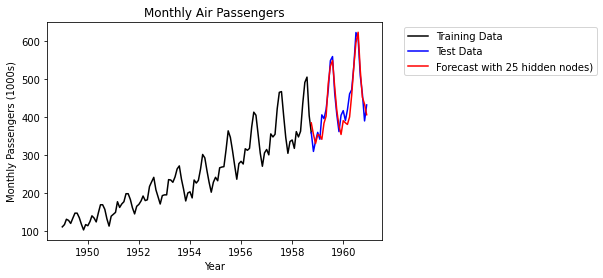

In [13]:
y_test_ = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1]
y_pred_ = scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1, 1)]))[:, -1]

fig, ax = plt.subplots()
plt.xlabel('Year')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Air Passengers')
plt.plot(df.iloc[:(k + len(y_train) + 1), :], color='black', label='Training Data')
plt.plot(pd.Series(y_test_, index=df.index[-len(y_test):]), color='blue', label='Test Data')
plt.plot(pd.Series(y_pred_, index=df.index[-len(y_test):]), color='red', label='Forecast with 25 hidden nodes)')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

#### MLP Using 5-Fold Cross validation

In [14]:
tscv = TimeSeriesSplit(n_splits=5)


def cross_validation_loss(hidden_neurons):
    #Use the mean squared error (MSE) as cross-validation loss.
    mse = []
    
    for train_split_, valid_split_ in tscv.split(X_train):    
        X_train_, y_train_ = X_train[train_split_], y_train[train_split_]
        X_valid_, y_valid_ = X_train[valid_split_], y_train[valid_split_] 

        mlp = MLPRegressor(hidden_layer_sizes=(hidden_neurons,), max_iter=500, random_state=1, shuffle=False)        
        mlp.fit(X_train_, y_train_)
        mse.append(mean_squared_error(y_valid_, mlp.predict(X_valid_)))
        
    return np.mean(mse)

#### Cross validation loss corresponding to different numbers of hidden nodes.

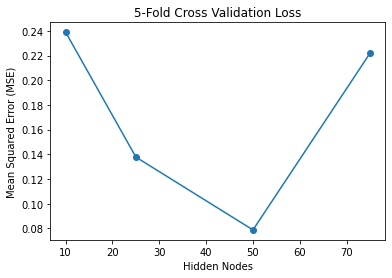

In [15]:
params = [10, 25, 50, 75]
mse = [cross_validation_loss(p) for p in params]

fig, ax = plt.subplots()
plt.xlabel('Hidden Nodes')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('5-Fold Cross Validation Loss')
plt.plot(params, mse, '-o')

#### Find the number of hidden nodes with the smallest cross validation loss.

In [16]:
params[np.argmin(mse)]

50

#### Fit an MLP model with 50 hidden nodes to the training data.

In [17]:
mlp = MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=1, shuffle=False)

In [18]:
mlp.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(50,), max_iter=500, random_state=1,
             shuffle=False)

#### Use the fitted MLP model to forecast the test data.

In [19]:
y_pred = mlp.predict(X_test)

#### Plot the data and the forecasts in the original scale.

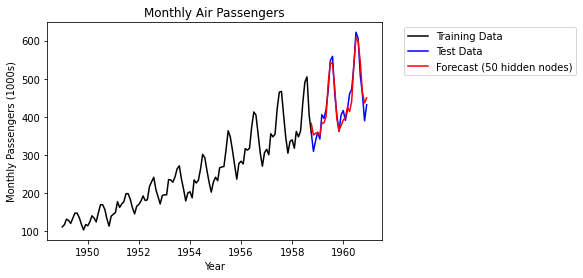

In [20]:
y_test_ = scaler.inverse_transform(np.hstack([X_test, y_test.reshape(-1, 1)]))[:, -1]
y_pred_ = scaler.inverse_transform(np.hstack([X_test, y_pred.reshape(-1, 1)]))[:, -1]

fig, ax = plt.subplots()
plt.xlabel('Year')
plt.ylabel('Monthly Passengers (1000s)')
plt.title('Monthly Air Passengers')
plt.plot(df.iloc[:(k + len(y_train) + 1), :], color='black', label='Training Data')
plt.plot(pd.Series(y_test_, index=df.index[-len(y_test):]), color='blue', label='Test Data')
plt.plot(pd.Series(y_pred_, index=df.index[-len(y_test):]), color='red', label='Forecast (50 hidden nodes)')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))